In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import random

In [5]:
!pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


In [7]:
# Paths to the train and test directories (adjust these paths according to your directory structure)
train_dir = r'C:\Users\ishwa\OneDrive\Attachments\dl project\FER-2013\train'
test_dir = r'C:\Users\ishwa\OneDrive\Attachments\dl project\FER-2013\test'

In [8]:
# Image dimensions
img_width, img_height = 48, 48
batch_size = 64
num_classes = 7  # Seven emotion classes


In [9]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, zoom_range=0.2, 
    width_shift_range=0.2, height_shift_range=0.2, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(img_width, img_height),
    batch_size=batch_size, class_mode='categorical',
    shuffle=False
)

Found 28739 images belonging to 7 classes.
Found 6325 images belonging to 7 classes.


In [10]:
# Optimized CNN Model
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\ishwa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,473,863 (9.44 MB)

 Trainable params: 2,472,967 (9.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# Callbacks for better training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

In [15]:
# Train the model
history = model.fit(train_generator, epochs=30, validation_data=test_generator, callbacks=callbacks)


Epoch 1/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 190s 423ms/step - accuracy: 0.2864 - loss: 1.7470 - val_accuracy: 0.3508 - val_loss: 1.6236 - learning_rate: 0.0010
Epoch 2/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 185s 410ms/step - accuracy: 0.3173 - loss: 1.6747 - val_accuracy: 0.4028 - val_loss: 1.6030 - learning_rate: 0.0010
Epoch 3/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 185s 410ms/step - accuracy: 0.3426 - loss: 1.6381 - val_accuracy: 0.4100 - val_loss: 1.5544 - learning_rate: 0.0010
Epoch 4/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 404ms/step - accuracy: 0.3606 - loss: 1.5983 - val_accuracy: 0.4329 - val_loss: 1.4582 - learning_rate: 0.0010
Epoch 5/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 180s 400ms/step - accuracy: 0.3863 - loss: 1.5584 - val_accuracy: 0.4229 - val_loss: 1.5256 - learning_rate: 0.0010
Epoch 6/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 179s 398ms/step - accuracy: 0.3943 - loss: 1.5395 - val_accuracy: 0.4901 - val_loss: 1.3382 - learning_rate: 0.0010
Epoch 7/30
450/450 ━━━━━━━━━━━━━━━━━━━━ 178s 396ms/step - accura

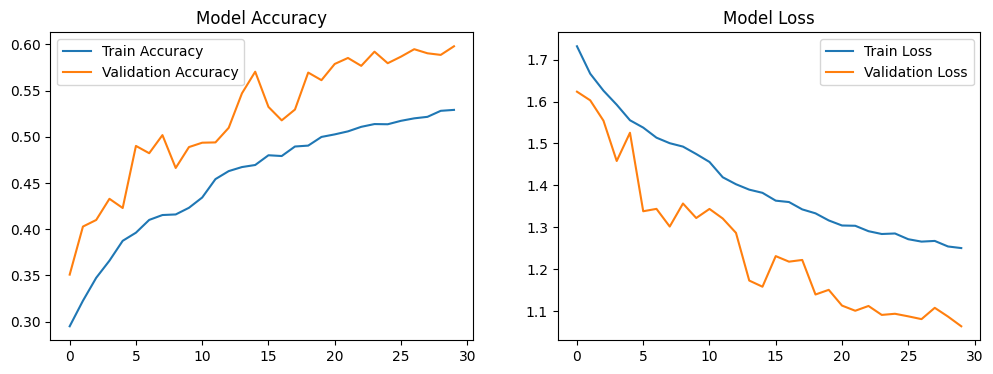

In [16]:
# Plot Accuracy & Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step


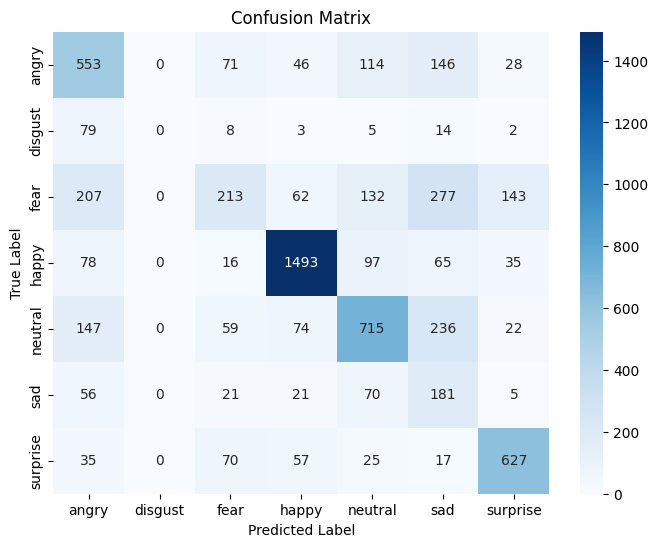

In [17]:

# Generate Confusion Matrix
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Grad-CAM Visualization

              precision    recall  f1-score   support

       angry       0.48      0.58      0.52       958
     disgust       0.00      0.00      0.00       111
        fear       0.47      0.21      0.29      1034
       happy       0.85      0.84      0.84      1784
     neutral       0.62      0.57      0.59      1253
         sad       0.19      0.51      0.28       354
    surprise       0.73      0.75      0.74       831

    accuracy                           0.60      6325
   macro avg       0.48      0.49      0.47      6325
weighted avg       0.62      0.60      0.59      6325



c:\Users\ishwa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ishwa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ishwa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo